In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('ggplot')
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from wordcloud import WordCloud

import statsmodels.api as sm


# Load CSVs

In [4]:
raw_interactions = pd.read_csv("data/RAW_interactions.csv")

In [5]:
raw_interactions.head()

user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...

In [6]:
raw_interactions.shape

(1132367, 5)

In [7]:
raw_interactions = raw_interactions.dropna(subset=["review"])

In [8]:
raw_interactions.shape

(1132198, 5)

In [9]:
raw_interactions.drop_duplicates(inplace=True)

# Raw recipes

In [10]:
raw_recipes = pd.read_csv("data/RAW_recipes.csv")
raw_recipes.head()

name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition  n_steps  \
0       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11   
1   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9   
2  [269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]        6   
3   [368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]       11   
4   [352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]        5   

                                               steps  \
0  ['make a choice and proceed with recipe', 'dep...   
1  ['preheat oven to 425 degrees f', 'press dough...   
2  ['brown ground beef in large pot', 'add choppe...   
3  ['place potatoes in a large pot of lightly sal...   
4  ['mix all ingredients& boil for 2 1 / 2 hours ...   

                                         description  \
0  autumn is my favorite time of year to cook! th...   
1  this recipe calls for the crust to be prebaked...   
2  this modified version of 'mom's' chili was a h...   
3  this is a super easy, great tasting, make ahea...   
4  my dh's amish mother raised him on this recipe...   

                                         ingredients  n_ingredients  
0  ['winter squash', 'mexican seasoning', 'mixed ...              7  
1  ['prepared pizza crust', 'sausage patty', 'egg...              6  
2  ['ground beef', 'yellow onions', 'diced tomato...             13  
3  ['spreadable cheese with garlic and herbs', 'n...             11  
4  ['tomato juice', 'apple cider vinegar', 'sugar...              8

In [11]:
raw_recipes.isna().any()

name               True
id                False
minutes           False
contributor_id    False
submitted         False
tags              False
nutrition         False
n_steps           False
steps             False
description        True
ingredients       False
n_ingredients     False
dtype: bool

In [12]:
raw_recipes = raw_recipes.dropna(subset=["name", "description"])

In [13]:
raw_recipes.isna().any()

name              False
id                False
minutes           False
contributor_id    False
submitted         False
tags              False
nutrition         False
n_steps           False
steps             False
description       False
ingredients       False
n_ingredients     False
dtype: bool

In [14]:
raw_recipes.shape

(226657, 12)

In [15]:
raw_recipes.drop_duplicates(inplace=True)

In [16]:
raw_recipes["ingredients"] = raw_recipes["ingredients"].apply(lambda x: eval(x) if x == x else np.nan)

In [17]:
raw_recipes = raw_recipes[raw_recipes.minutes <= 300]

In [18]:
raw_recipes.shape

(216892, 12)

In [19]:
raw_recipes['nutrition'] = raw_recipes['nutrition'].str.strip('[]').str.split(',')

In [20]:
nutrition_columns = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carb']
raw_recipes[nutrition_columns] = pd.DataFrame(raw_recipes['nutrition'].tolist(), index=raw_recipes.index)
raw_recipes = raw_recipes.drop(columns=['nutrition'])

In [21]:
raw_recipes.shape

(216892, 18)

In [22]:
raw_recipes.head()

name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  n_steps  \
0  ['60-minutes-or-less', 'time-to-make', 'course...       11   
1  ['30-minutes-or-less', 'time-to-make', 'course...        9   
2  ['time-to-make', 'course', 'preparation', 'mai...        6   
3  ['60-minutes-or-less', 'time-to-make', 'course...       11   
4  ['weeknight', 'time-to-make', 'course', 'main-...        5   

                                               steps  \
0  ['make a choice and proceed with recipe', 'dep...   
1  ['preheat oven to 425 degrees f', 'press dough...   
2  ['brown ground beef in large pot', 'add choppe...   
3  ['place potatoes in a large pot of lightly sal...   
4  ['mix all ingredients& boil for 2 1 / 2 hours ...   

                                         description  \
0  autumn is my favorite time of year to cook! th...   
1  this recipe calls for the crust to be prebaked...   
2  this modified version of 'mom's' chili was a h...   
3  this is a super easy, great tasting, make ahea...   
4  my dh's amish mother raised him on this recipe...   

                                         ingredients  n_ingredients calories  \
0  [winter squash, mexican seasoning, mixed spice...              7     51.5   
1  [prepared pizza crust, sausage patty, eggs, mi...              6    173.4   
2  [ground beef, yellow onions, diced tomatoes, t...             13    269.8   
3  [spreadable cheese with garlic and herbs, new ...             11    368.1   
4  [tomato juice, apple cider vinegar, sugar, sal...              8    352.9   

     fat   sugar sodium protein saturated_fat   carb  
0    0.0    13.0    0.0     2.0           0.0    4.0  
1   18.0     0.0   17.0    22.0          35.0    1.0  
2   22.0    32.0   48.0    39.0          27.0    5.0  
3   17.0    10.0    2.0    14.0           8.0   20.0  
4    1.0   337.0   23.0     3.0           0.0   28.0

 nutrition:  (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV) , and carbohydrates (PDV))

In [23]:
raw_recipes.rename({"id": "recipe_id"}, axis=1, inplace=True)

In [24]:
raw_recipes.isna().any()

name              False
recipe_id         False
minutes           False
contributor_id    False
submitted         False
tags              False
n_steps           False
steps             False
description       False
ingredients       False
n_ingredients     False
calories          False
fat               False
sugar             False
sodium            False
protein           False
saturated_fat     False
carb              False
dtype: bool

Find recipes with most interactions

In [25]:
raw_interactions.head()

user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...

In [26]:
raw_interactions["recipe_id"].value_counts() 

recipe_id
2886      1609
27208     1601
89204     1579
39087     1448
67256     1322
          ... 
145160       1
87750        1
60656        1
310237       1
306785       1
Name: count, Length: 231630, dtype: int64

TODO neki plot

# Get recipes with >= 10 reviews

In [27]:
merged_df = pd.merge(raw_recipes, raw_interactions, on='recipe_id')
reviews_count = merged_df.groupby('recipe_id').size().reset_index(name='review_count')
reviews_count

recipe_id  review_count
0              39             1
1              40             9
2              43             1
3              45             3
4              46             2
...           ...           ...
216881     537459             1
216882     537485             1
216883     537543             1
216884     537671             1
216885     537716             1

[216886 rows x 2 columns]

In [28]:
recipes_to_keep = reviews_count[reviews_count.review_count >= 10].recipe_id.values

In [29]:
len(recipes_to_keep)

19854

In [30]:
#top_1000_recipes = raw_interactions["recipe_id"].value_counts().index[:1000]
#top_1000_recipes

In [31]:
interactions_df = raw_interactions[raw_interactions.recipe_id.isin(recipes_to_keep)].copy()
interactions_df.shape

(557943, 5)

In [32]:
recipes_df = raw_recipes[raw_recipes.recipe_id.isin(recipes_to_keep)].copy()
recipes_df.shape

(19854, 18)

# Data exploration - interactions

- wordcloud najcesce rijeci u reviews
- correlation id user i rating - dal odredeni useri daju pozitivnije ocjene
- koliko ratinga ima koji user - dal neki npr samo masu masu ratea

# Data exploration - Recipes

- najcesci ingredienti
- histogram duration (minutes)
- histogram number of ingredients
- korelacija ingredients, minutes, kalorije, steps

- korelirat minute i broj stepova i testirat significance ---> ako je korelacija koristimo samo jedan, kazemo da predstavlja recipe complexity 

In [33]:
recipes_df.dtypes

name              object
recipe_id          int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
calories          object
fat               object
sugar             object
sodium            object
protein           object
saturated_fat     object
carb              object
dtype: object

In [34]:
recipes_df['calories'] = pd.to_numeric(recipes_df['calories'], errors='coerce')
recipes_df['fat'] = pd.to_numeric(recipes_df['fat'], errors='coerce')
recipes_df['sugar'] = pd.to_numeric(recipes_df['sugar'], errors='coerce')
recipes_df['protein'] = pd.to_numeric(recipes_df['protein'], errors='coerce')
recipes_df['carb'] = pd.to_numeric(recipes_df['carb'], errors='coerce')
recipes_df['sodium'] = pd.to_numeric(recipes_df['carb'], errors='coerce')
recipes_df['saturated_fat'] = pd.to_numeric(recipes_df['saturated_fat'], errors='coerce')

In [35]:
recipes_df.dtypes

name               object
recipe_id           int64
minutes             int64
contributor_id      int64
submitted          object
tags               object
n_steps             int64
steps              object
description        object
ingredients        object
n_ingredients       int64
calories          float64
fat               float64
sugar             float64
sodium            float64
protein           float64
saturated_fat     float64
carb              float64
dtype: object

In [36]:
recipes_df.calories.describe()

count    19854.000000
mean       452.645140
std        787.287689
min          0.000000
25%        169.400000
50%        298.650000
75%        494.000000
max      38680.100000
Name: calories, dtype: float64

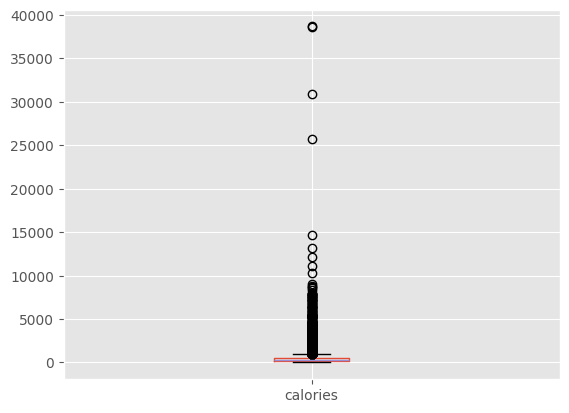

In [37]:
recipes_df[["calories"]].boxplot()
plt.show()

In [39]:
Q1 = recipes_df['calories'].quantile(0.25)
Q3 = recipes_df['calories'].quantile(0.75)
IQR = Q3 - Q1

filter = (recipes_df['calories'] >= Q1 - 1.5 * IQR) & (recipes_df['calories'] <= Q3 + 1.5 *IQR)
recipes_df = recipes_df.loc[filter]

In [40]:
recipes_df

name  recipe_id  minutes  \
16                                         chile rellenos      43026       45   
17                                         chinese  candy      23933       15   
33                               grilled  venison burgers      54100       26   
34                     healthy for them  yogurt popsicles      67664       10   
36      how i got my family to eat spinach  spinach ca...      25775       50   
...                                                   ...        ...      ...   
231528                            zucchini corn casserole     126852       60   
231539                         zucchini parmesan pancakes      70501       26   
231566                                            zucotte      96811       65   
231587             zuppa di pesce  cioppino  or fish stew     116488       60   
231600            zuppa toscana soup   olive garden clone     208429       60   

        contributor_id   submitted  \
16               52268  2002-10-14   
17               35268  2002-03-29   
33               68357  2003-02-15   
34               91970  2003-07-26   
36               37305  2002-04-22   
...                ...         ...   
231528           28604  2005-06-21   
231539           89831  2003-09-04   
231566           65056  2004-08-03   
231587           58104  2005-04-12   
231600          346694  2007-01-30   

                                                     tags  n_steps  \
16      ['60-minutes-or-less', 'time-to-make', 'course...        9   
17      ['15-minutes-or-less', 'time-to-make', 'course...        4   
33      ['30-minutes-or-less', 'time-to-make', 'course...       13   
34      ['15-minutes-or-less', 'time-to-make', 'course...        3   
36      ['60-minutes-or-less', 'time-to-make', 'course...        5   
...                                                   ...      ...   
231528  ['60-minutes-or-less', 'time-to-make', 'course...        8   
231539  ['30-minutes-or-less', 'time-to-make', 'course...        6   
231566  ['time-to-make', 'course', 'main-ingredient', ...       10   
231587  ['60-minutes-or-less', 'time-to-make', 'course...        9   
231600  ['60-minutes-or-less', 'time-to-make', 'course...       10   

                                                    steps  \
16      ['drain green chiles', 'sprinkle cornstarch on...   
17      ['melt butterscotch chips in heavy saucepan ov...   
33      ['in bowl , mix dry ingredients', 'add venison...   
34      ['mix all the ingredients using a blender', 'p...   
36      ['preheat oven to 350 degrees', 'place spinach...   
...                                                   ...   
231528  ['trim and scrub zucchini and cook them in boi...   
231539  ['in a bowl , combine all ingredients except b...   
231566  ['in a large , heavy saucpan , melt 1 tbs of t...   
231587  ['in a pot add 5 cups water and shrimp shells ...   
231600  ['bring chicken stock and water to a light boi...   

                                              description  \
16      a favorite from a local restaurant no longer i...   
17      a little different, and oh so good. i include ...   
33                   delicious venison burgers with that    
34      my children and their friends ask for my homem...   
36      if spinach scares you, this is one recipe that...   
...                                                   ...   
231528  my grandma lorraine stromgren would listen to ...   
231539  if you love zucchini and parmesan cheese, then...   
231566  a garlicky braised winter squash dish that cou...   
231587  whatever you may call it this italian named fi...   
231600  i have tried quite a few different recipes tha...   

                                              ingredients  n_ingredients  \
16      [egg roll wrap, whole green chilies, cheese, c...              5   
17      [butterscotch chips, chinese noodles, salted p...              3   
33      [ground venison, egg substitute, non-fat powde...             10   
34         [

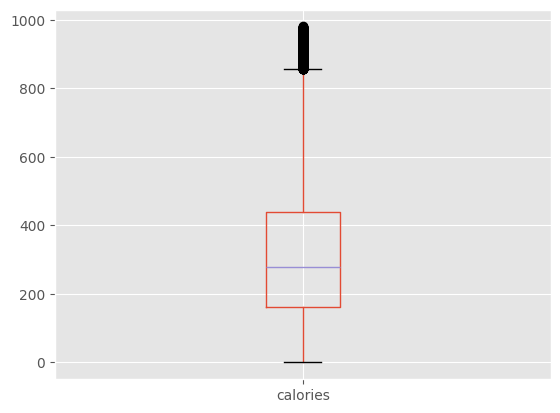

In [41]:
recipes_df[["calories"]].boxplot()
plt.show()

# Sentiment Analysis


In [42]:
interactions_df["review"].iloc[1]

"Wow!  My family loves this recipe and it is a great winter meal.  I do have to say that I adjusted a little but the base remains the same.  Here's what I did different:  I peeled my potatoes and diced them very small. I left out the creamed corn, nutmeg, cayenne pepper, and parsley.  Instead I used approx. 1 tsp of Old Bay seasoning. Then right before I stirred in the crab meat, I used my potato masher to mash up some of the potatoes.  This makes the chowder a little thicker.  These are all just my personal preferences.  I have made this several times and have forgotten to review it.  It's awesome!  Thanks Pantry Chef Starkey."

In [43]:
interactions_df['rating'].value_counts().sort_index().plot(kind = 'bar',figsize = (10,5), title=  'Reviews Plot')

<Axes: title={'center': 'Reviews Plot'}, xlabel='rating'>

# Sentiment

In [44]:
example = interactions_df["review"].iloc[1]
example

"Wow!  My family loves this recipe and it is a great winter meal.  I do have to say that I adjusted a little but the base remains the same.  Here's what I did different:  I peeled my potatoes and diced them very small. I left out the creamed corn, nutmeg, cayenne pepper, and parsley.  Instead I used approx. 1 tsp of Old Bay seasoning. Then right before I stirred in the crab meat, I used my potato masher to mash up some of the potatoes.  This makes the chowder a little thicker.  These are all just my personal preferences.  I have made this several times and have forgotten to review it.  It's awesome!  Thanks Pantry Chef Starkey."

In [45]:
sia = SentimentIntensityAnalyzer()

In [46]:
sia.polarity_scores(example)

{'neg': 0.02, 'neu': 0.832, 'pos': 0.148, 'compound': 0.9436}

In [47]:
interactions_df['review_VADER_compound'] = interactions_df['review'].apply(lambda x: sia.polarity_scores(x)['compound']).astype(float)

In [48]:
interactions_df['review_VADER_class'] = interactions_df['review_VADER_compound'].apply(lambda x: "Positive" if x > 0.5 else ("Negative" if x < -0.5 else "Neutral"))

In [49]:
interactions_df.head()

user_id  recipe_id        date  rating  \
31    56680      79222  2006-11-11       5   
43   183565      79222  2006-02-13       5   
44   101823      79222  2006-03-21       5   
45   349752      79222  2007-04-07       5   
46   446143      79222  2008-02-01       4   

                                               review  review_VADER_compound  \
31  Oh, This was wonderful!  Had a soup and salad ...                 0.9012   
43  Wow!  My family loves this recipe and it is a ...                 0.9436   
44  Excellent chowder.  This was the perfect warm-...                 0.8271   
45  Tasty, low fat, fast & easy!  I added 1tsp. of...                 0.8065   
46  Oh, how wonderful!  I doubled the crab, and ad...                 0.9150   

   review_VADER_class  
31           Positive  
43           Positive  
44           Positive  
45           Positive  
46           Positive

In [50]:
interactions_df.rating.describe()

count    557943.000000
mean          4.440411
std           1.280851
min           0.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [51]:
recipes_df['recipe_VADER_compound'] = recipes_df['description'].apply(lambda x: sia.polarity_scores(x)['compound']).astype(float)

In [52]:
recipes_df['recipe_VADER_class'] = recipes_df['recipe_VADER_compound'].apply(lambda x: "Positive" if x > 0.5 else ("Negative" if x < -0.5 else "Neutral"))

In [53]:
recipes_df.head()

name  recipe_id  minutes  \
16                                     chile rellenos      43026       45   
17                                     chinese  candy      23933       15   
33                           grilled  venison burgers      54100       26   
34                 healthy for them  yogurt popsicles      67664       10   
36  how i got my family to eat spinach  spinach ca...      25775       50   

    contributor_id   submitted  \
16           52268  2002-10-14   
17           35268  2002-03-29   
33           68357  2003-02-15   
34           91970  2003-07-26   
36           37305  2002-04-22   

                                                 tags  n_steps  \
16  ['60-minutes-or-less', 'time-to-make', 'course...        9   
17  ['15-minutes-or-less', 'time-to-make', 'course...        4   
33  ['30-minutes-or-less', 'time-to-make', 'course...       13   
34  ['15-minutes-or-less', 'time-to-make', 'course...        3   
36  ['60-minutes-or-less', 'time-to-make', 'course...        5   

                                                steps  \
16  ['drain green chiles', 'sprinkle cornstarch on...   
17  ['melt butterscotch chips in heavy saucepan ov...   
33  ['in bowl , mix dry ingredients', 'add venison...   
34  ['mix all the ingredients using a blender', 'p...   
36  ['preheat oven to 350 degrees', 'place spinach...   

                                          description  \
16  a favorite from a local restaurant no longer i...   
17  a little different, and oh so good. i include ...   
33               delicious venison burgers with that    
34  my children and their friends ask for my homem...   
36  if spinach scares you, this is one recipe that...   

                                          ingredients  n_ingredients  \
16  [egg roll wrap, whole green chilies, cheese, c...              5   
17  [butterscotch chips, chinese noodles, salted p...              3   
33  [ground venison, egg substitute, non-fat powde...             10   
34     [milk, frozen juice concentrate, plain yogurt]              3   
36  [frozen chopped spinach, egg, salt, black pepp...              8   

    calories   fat  sugar  sodium  protein  saturated_fat  carb  \
16      94.0  10.0    0.0     0.0     11.0           21.0   0.0   
17     232.7  21.0   77.0     8.0      6.0           38.0   8.0   
33     190.9  10.0   10.0     2.0     45.0           15.0   2.0   
34     164.6   3.0    5.0    11.0      4.0            6.0  11.0   
36     166.1  16.0    6.0     3.0     19.0           26.0   3.0   

    recipe_VADER_compound recipe_VADER_class  
16                 0.1027            Neutral  
17                 0.5777           Positive  
33                 0.5719           Positive  
34                 0.7424           Positive  
36                 0.8980           Positive

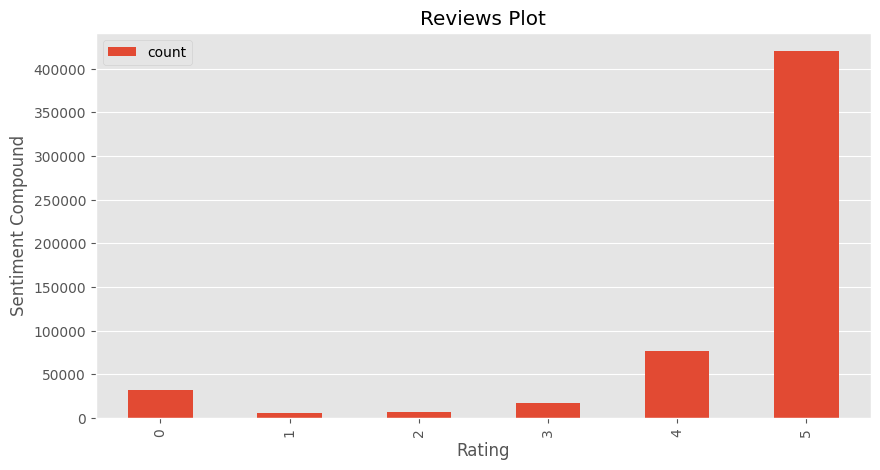

In [54]:
ax = sns.barplot(data= interactions_df, x = 'rating' , y = 'review_VADER_compound')
#ax.set_title("Compund Scores vs Rating for Reviews")
ax.set_ylabel("Sentiment Compound")
ax.set_xlabel("Rating")
plt.show()

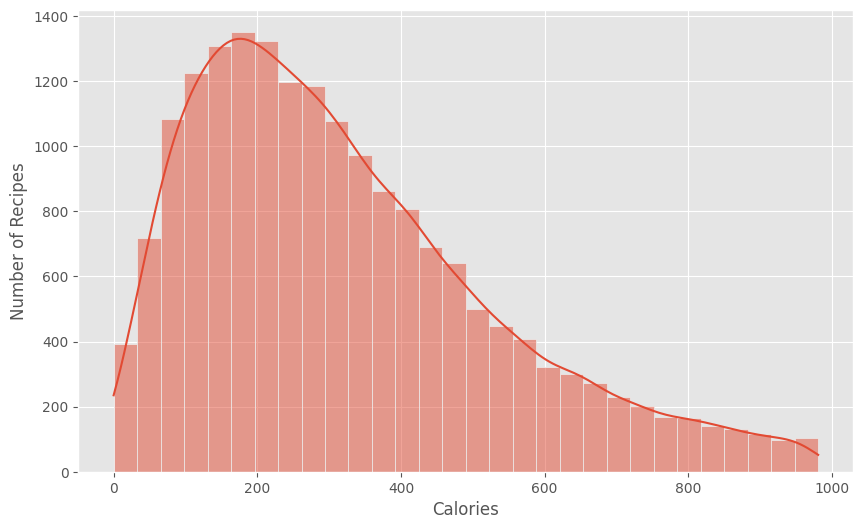

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(recipes_df['calories'], bins=30, kde=True)
#plt.title('Distribution of Calories in Recipes')
plt.xlabel('Calories')
plt.ylabel('Number of Recipes')
plt.show()

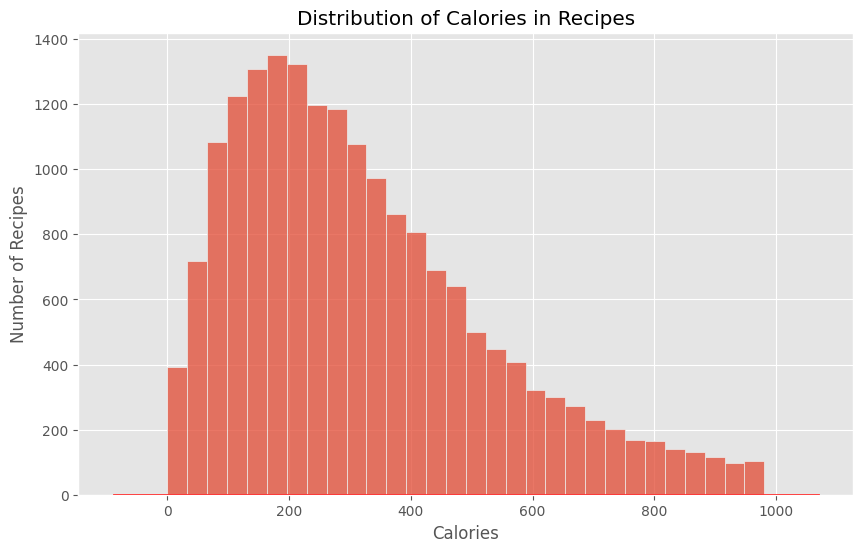

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(recipes_df['calories'], bins=30, kde=False)
sns.kdeplot(recipes_df['calories'], color='red', linewidth=2)

plt.title('Distribution of Calories in Recipes')
plt.xlabel('Calories')
plt.ylabel('Number of Recipes')
plt.show()

In [57]:
recipes_df.minutes.describe()

count    18443.000000
mean        47.320772
std         44.672660
min          0.000000
25%         20.000000
50%         35.000000
75%         60.000000
max        300.000000
Name: minutes, dtype: float64

# High engagement

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb

In [59]:
merged_df = pd.merge(recipes_df, interactions_df, on='recipe_id')
reviews_count = merged_df.groupby('recipe_id').size().reset_index(name='review_count')

In [60]:
recipes_with_reviews = pd.merge(recipes_df, reviews_count, on='recipe_id')

In [61]:
recipes_with_reviews.review_count.describe()

count    18443.000000
mean        28.140866
std         51.528465
min         10.000000
25%         12.000000
50%         16.000000
75%         26.000000
max       1609.000000
Name: review_count, dtype: float64

In [62]:
recipes_with_reviews["review_count"].quantile(0.25)

np.float64(12.0)

In [63]:
high_df = recipes_with_reviews[recipes_with_reviews["review_count"] > recipes_with_reviews["review_count"].quantile(0.75)].copy()
high_df["high_eng"] = 1

In [64]:
low_df= recipes_with_reviews[recipes_with_reviews["review_count"] < recipes_with_reviews["review_count"].quantile(0.25)].copy()
low_df["high_eng"] = 0

In [65]:
df = pd.concat([high_df, low_df], axis=0, ignore_index=True)

In [66]:
df.columns

Index(['name', 'recipe_id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat',
       'carb', 'recipe_VADER_compound', 'recipe_VADER_class', 'review_count',
       'high_eng'],
      dtype='object')

In [67]:
df.head()

name  recipe_id  minutes  \
0  how i got my family to eat spinach  spinach ca...      25775       50   
1                         land of nod  cinnamon buns      22526       35   
2                          never weep  whipped cream      74805        5   
3                         say what   banana sandwich      95926        5   
4                 the best  banana bread  or muffins      39363       70   

   contributor_id   submitted  \
0           37305  2002-04-22   
1           29212  2002-03-14   
2           87877  2003-11-01   
3          118163  2004-07-20   
4           51579  2002-09-03   

                                                tags  n_steps  \
0  ['60-minutes-or-less', 'time-to-make', 'course...        5   
1  ['60-minutes-or-less', 'time-to-make', 'course...        7   
2  ['15-minutes-or-less', 'time-to-make', 'course...        4   
3  ['15-minutes-or-less', 'time-to-make', 'course...        4   
4  ['weeknight', 'time-to-make', 'course', 'main-...       10   

                                               steps  \
0  ['preheat oven to 350 degrees', 'place spinach...   
1  ['before you turn in for the night , grease a ...   
2  ['whip all ingredients together until firm pea...   
3  ['spread a tablespoon on one side of each slic...   
4  ['cream together butter and sugar', 'blend in ...   

                                         description  \
0  if spinach scares you, this is one recipe that...   
1  i have made this several times and it's dead e...   
2  i don't know where i got this, but it works. t...   
3             you just have to try it to believe it.   
4  okay, another banana bread recipe...but maybe ...   

                                         ingredients  ...   fat  sugar  \
0  [frozen chopped spinach, egg, salt, black pepp...  ...  16.0    6.0   
1  [rolls, brown sugar, instant vanilla pudding, ...  ...  18.0  116.0   
2  [whipping cream, vanilla instant pudding mix, ...  ...  45.0    2.0   
3                 [white bread, mayonnaise, bananas]  ...   3.0   66.0   
4  [butter, sugar, eggs, bananas, water, baking s...  ...   9.0   65.0   

   sodium  protein  saturated_fat  carb  recipe_VADER_compound  \
0     3.0     19.0           26.0   3.0                 0.8980   
1    34.0     28.0           22.0  34.0                 0.8074   
2     0.0      3.0           91.0   0.0                -0.2242   
3    17.0     10.0            2.0  17.0                 0.0000   
4     9.0      5.0           18.0   9.0                 0.7339   

   recipe_VADER_class  review_count high_eng  
0            Positive           113        1  
1            Positive            51        1  
2             Neutral            80        1  
3             Neutral            43        1  
4            Positive            27        1  

[5 rows x 22 columns]

In [68]:
df['tags'] = df['tags'].str.strip("[]").str.replace("'", "").str.split(',')

In [69]:
df["n_tags"] = df["tags"].apply(lambda x: len(x))

In [70]:
df.head()

name  recipe_id  minutes  \
0  how i got my family to eat spinach  spinach ca...      25775       50   
1                         land of nod  cinnamon buns      22526       35   
2                          never weep  whipped cream      74805        5   
3                         say what   banana sandwich      95926        5   
4                 the best  banana bread  or muffins      39363       70   

   contributor_id   submitted  \
0           37305  2002-04-22   
1           29212  2002-03-14   
2           87877  2003-11-01   
3          118163  2004-07-20   
4           51579  2002-09-03   

                                                tags  n_steps  \
0  [60-minutes-or-less,  time-to-make,  course,  ...        5   
1  [60-minutes-or-less,  time-to-make,  course,  ...        7   
2  [15-minutes-or-less,  time-to-make,  course,  ...        4   
3  [15-minutes-or-less,  time-to-make,  course,  ...        4   
4  [weeknight,  time-to-make,  course,  main-ingr...       10   

                                               steps  \
0  ['preheat oven to 350 degrees', 'place spinach...   
1  ['before you turn in for the night , grease a ...   
2  ['whip all ingredients together until firm pea...   
3  ['spread a tablespoon on one side of each slic...   
4  ['cream together butter and sugar', 'blend in ...   

                                         description  \
0  if spinach scares you, this is one recipe that...   
1  i have made this several times and it's dead e...   
2  i don't know where i got this, but it works. t...   
3             you just have to try it to believe it.   
4  okay, another banana bread recipe...but maybe ...   

                                         ingredients  ...  sugar  sodium  \
0  [frozen chopped spinach, egg, salt, black pepp...  ...    6.0     3.0   
1  [rolls, brown sugar, instant vanilla pudding, ...  ...  116.0    34.0   
2  [whipping cream, vanilla instant pudding mix, ...  ...    2.0     0.0   
3                 [white bread, mayonnaise, bananas]  ...   66.0    17.0   
4  [butter, sugar, eggs, bananas, water, baking s...  ...   65.0     9.0   

   protein  saturated_fat  carb  recipe_VADER_compound  recipe_VADER_class  \
0     19.0           26.0   3.0                 0.8980            Positive   
1     28.0           22.0  34.0                 0.8074            Positive   
2      3.0           91.0   0.0                -0.2242             Neutral   
3     10.0            2.0  17.0                 0.0000             Neutral   
4      5.0           18.0   9.0                 0.7339            Positive   

   review_count  high_eng n_tags  
0           113         1     25  
1            51         1      9  
2            80         1     14  
3            43         1     30  
4            27         1     22  

[5 rows x 23 columns]

In [71]:
df = df.drop(["name", "submitted", "recipe_id", "steps", "description", "tags", "ingredients", "recipe_VADER_class", "review_count"], axis=1)

In [74]:
df.columns

Index(['minutes', 'contributor_id', 'n_steps', 'n_ingredients', 'calories',
       'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carb',
       'recipe_VADER_compound', 'high_eng', 'n_tags'],
      dtype='object')

In [75]:
df

minutes  contributor_id  n_steps  n_ingredients  calories   fat  sugar  \
0          50           37305        5              8     166.1  16.0    6.0   
1          35           29212        7              6     575.3  18.0  116.0   
2           5           87877        4              4     276.3  45.0    2.0   
3           5          118163        4              3     238.0   3.0   66.0   
4          70           51579       10             11     175.7   9.0   65.0   
...       ...             ...      ...            ...       ...   ...    ...   
8602       25          705251        6              6     258.8  11.0    8.0   
8603       20           39835        4              5     102.5   8.0   27.0   
8604       70           50976        7              8      51.2   2.0    7.0   
8605       60           28604        8             10     195.1  16.0   23.0   
8606       26           89831        6             11     397.2  43.0   15.0   

      sodium  protein  saturated_fat  carb  recipe_VADER_compound  high_eng  \
0        3.0     19.0           26.0   3.0                 0.8980         1   
1       34.0     28.0           22.0  34.0                 0.8074         1   
2        0.0      3.0           91.0   0.0                -0.2242         1   
3       17.0     10.0            2.0  17.0                 0.0000         1   
4        9.0      5.0           18.0   9.0                 0.7339         1   
...      ...      ...            ...   ...                    ...       ...   
8602    13.0     14.0           20.0  13.0                 0.6801         0   
8603     4.0      9.0            3.0   4.0                 0.7184         0   
8604     2.0      5.0            3.0   2.0                 0.7983         0   
8605     6.0     19.0           28.0   6.0                 0.8439         0   
8606     8.0     23.0           51.0   8.0                 0.9201         0   

      n_tags  
0         25  
1          9  
2         14  
3         30  
4         22  
...      ...  
8602      27  
8603      25  
8604      31  
8605      29  
8606       7  

[8607 rows x 14 columns]

In [76]:
X = df.drop(columns=['high_eng']).apply(pd.to_numeric, errors='coerce')
y = df['high_eng']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

In [79]:
sum(X_train.isna().sum().values)

np.int64(0)

In [80]:
if X_train.dtypes.eq("object").any():
    print("1")

In [81]:
X_train.dtypes.value_counts()

float64    8
int64      5
Name: count, dtype: int64

In [82]:
X_train.head()

minutes  contributor_id  n_steps  n_ingredients  calories   fat  sugar  \
6749      135          109855        8              7     183.3  16.0   51.0   
6244       10           28604        4              6     184.3  10.0   87.0   
228        15           37449       11             11     231.9  28.0   20.0   
8550       20          280271        6             10     177.1   8.0    0.0   
7256       15         1550077        7             10     293.2  16.0    1.0   

      sodium  protein  saturated_fat  carb  recipe_VADER_compound  n_tags  
6749     6.0      6.0           29.0   6.0                 0.9299       8  
6244     8.0     13.0           27.0   8.0                 0.9214      49  
228      5.0      8.0           13.0   5.0                 0.7845      29  
8550     1.0     54.0            3.0   1.0                 0.5719       9  
7256     1.0     92.0           10.0   1.0                 0.9380      18

In [83]:
model.fit(X_train, y_train)

c:\Users\Gabriela\anaconda3\envs\css-course\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
y_pred = model.predict(X_test)

In [85]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.57


In [86]:
auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {auc:.2f}')

AUC-ROC: 0.56


In [87]:
final_model = model

In [88]:
import shap

explainer = shap.Explainer(final_model, X_test) 
shap_values = explainer(X_test)

c:\Users\Gabriela\anaconda3\envs\css-course\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


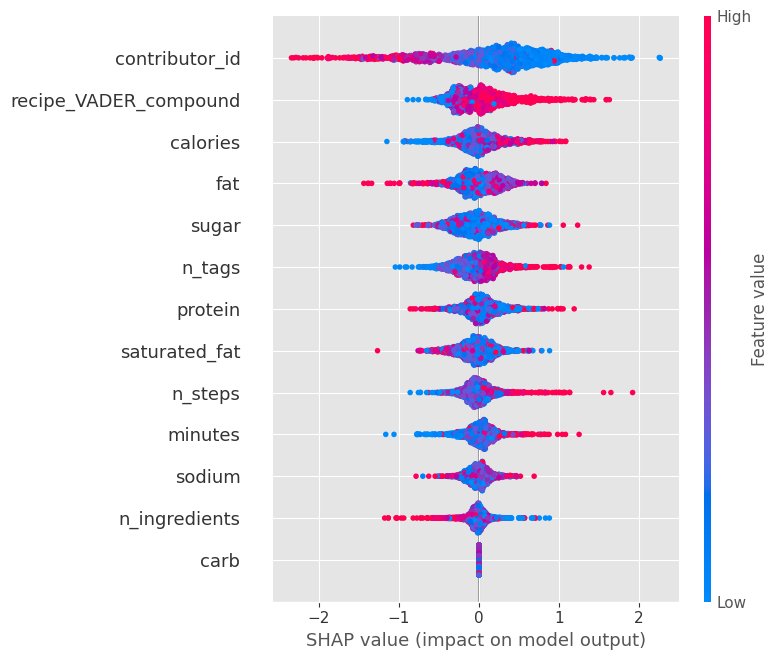

In [89]:
shap.summary_plot(shap_values, X_test)

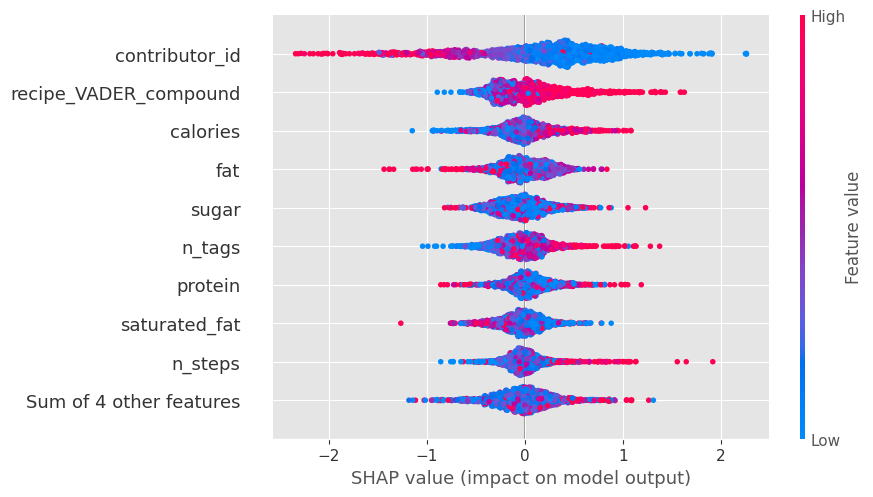

In [90]:
shap.plots.beeswarm(shap_values)

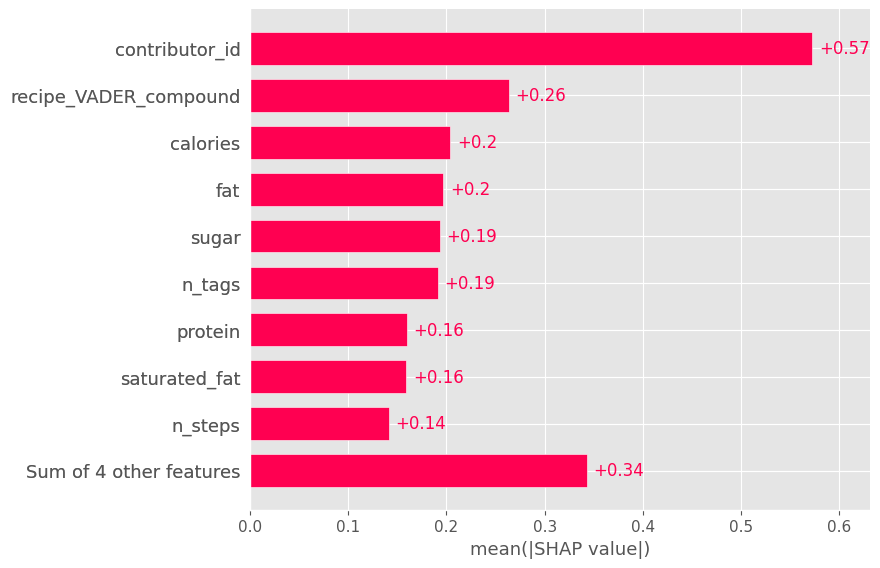

In [91]:
shap.plots.bar(shap_values)

# 1. Do recipes with higher calories and macros have more reviews?

- YES

In [93]:
merged_df = pd.merge(recipes_df, interactions_df, on='recipe_id')
reviews_count = merged_df.groupby('recipe_id').size().reset_index(name='review_count')

In [94]:
recipes_with_reviews = pd.merge(recipes_df, reviews_count, on='recipe_id')

In [95]:
recipes_with_reviews

name  recipe_id  minutes  \
0                                         chile rellenos      43026       45   
1                                         chinese  candy      23933       15   
2                               grilled  venison burgers      54100       26   
3                     healthy for them  yogurt popsicles      67664       10   
4      how i got my family to eat spinach  spinach ca...      25775       50   
...                                                  ...        ...      ...   
18438                            zucchini corn casserole     126852       60   
18439                         zucchini parmesan pancakes      70501       26   
18440                                            zucotte      96811       65   
18441             zuppa di pesce  cioppino  or fish stew     116488       60   
18442            zuppa toscana soup   olive garden clone     208429       60   

       contributor_id   submitted  \
0               52268  2002-10-14   
1               35268  2002-03-29   
2               68357  2003-02-15   
3               91970  2003-07-26   
4               37305  2002-04-22   
...               ...         ...   
18438           28604  2005-06-21   
18439           89831  2003-09-04   
18440           65056  2004-08-03   
18441           58104  2005-04-12   
18442          346694  2007-01-30   

                                                    tags  n_steps  \
0      ['60-minutes-or-less', 'time-to-make', 'course...        9   
1      ['15-minutes-or-less', 'time-to-make', 'course...        4   
2      ['30-minutes-or-less', 'time-to-make', 'course...       13   
3      ['15-minutes-or-less', 'time-to-make', 'course...        3   
4      ['60-minutes-or-less', 'time-to-make', 'course...        5   
...                                                  ...      ...   
18438  ['60-minutes-or-less', 'time-to-make', 'course...        8   
18439  ['30-minutes-or-less', 'time-to-make', 'course...        6   
18440  ['time-to-make', 'course', 'main-ingredient', ...       10   
18441  ['60-minutes-or-less', 'time-to-make', 'course...        9   
18442  ['60-minutes-or-less', 'time-to-make', 'course...       10   

                                                   steps  \
0      ['drain green chiles', 'sprinkle cornstarch on...   
1      ['melt butterscotch chips in heavy saucepan ov...   
2      ['in bowl , mix dry ingredients', 'add venison...   
3      ['mix all the ingredients using a blender', 'p...   
4      ['preheat oven to 350 degrees', 'place spinach...   
...                                                  ...   
18438  ['trim and scrub zucchini and cook them in boi...   
18439  ['in a bowl , combine all ingredients except b...   
18440  ['in a large , heavy saucpan , melt 1 tbs of t...   
18441  ['in a pot add 5 cups water and shrimp shells ...   
18442  ['bring chicken stock and water to a light boi...   

                                             description  \
0      a favorite from a local restaurant no longer i...   
1      a little different, and oh so good. i include ...   
2                   delicious venison burgers with that    
3      my children and their friends ask for my homem...   
4      if spinach scares you, this is one recipe that...   
...                                                  ...   
18438  my grandma lorraine stromgren would listen to ...   
18439  if you love zucchini and parmesan cheese, then...   
18440  a garlicky braised winter squash dish that cou...   
18441  whatever you may call it this italian named fi...   
18442  i have tried quite a few different recipes tha...   

                                             ingredients  ...  calories   fat  \
0      [egg roll wrap, whole green chilies, cheese, c...  ...      94.0  10.0   
1      [butterscotch chips, chinese noodles, salted p...  ...     232.7  21.0   
2      [ground venison, egg substitute, non-fat powde...  ...     190.9  10.0   
3         [milk, frozen juice concentrate, plain yo

In [96]:
recipes_with_reviews['review_count'] = pd.to_numeric(recipes_with_reviews['review_count'], errors='coerce')

In [97]:
recipes_with_reviews = recipes_with_reviews.dropna(subset=['calories', 'review_count'])

X = recipes_with_reviews['calories']
y = recipes_with_reviews['review_count']
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit() 
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.21
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           0.000814
Time:                        20:47:45   Log-Likelihood:                -98868.
No. Observations:               18443   AIC:                         1.977e+05
Df Residuals:                   18441   BIC:                         1.978e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.1971      0.693     37.779      0.0

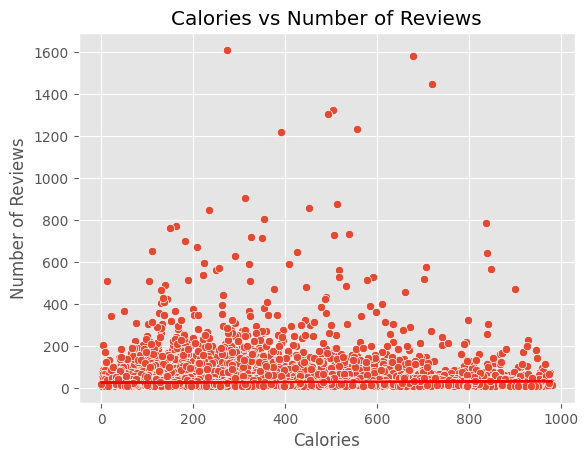

In [98]:
sns.scatterplot(data=recipes_with_reviews, x='calories', y='review_count')
plt.plot(recipes_with_reviews['calories'], predictions, color='red')
plt.title('Calories vs Number of Reviews')
plt.xlabel('Calories')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
recipes_with_reviews = recipes_with_reviews.dropna(subset=['calories', 'fat', 'sugar', 'protein', 'carb', 'review_count'])

X = recipes_with_reviews[['calories', 'fat', 'sugar', 'protein', 'carb']]
y = recipes_with_reviews['review_count']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.881
Date:                Fri, 17 Jan 2025   Prob (F-statistic):             0.0133
Time:                        20:47:45   Log-Likelihood:                -98867.
No. Observations:               18443   AIC:                         1.977e+05
Df Residuals:                   18437   BIC:                         1.978e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3211      0.713     36.939      0.0

# 2. Do recipes with higher calories have reviews with more positive sentiment?

- NO

In [100]:
avg_sentiment = merged_df.groupby('recipe_id')['review_VADER_compound'].mean().reset_index(name='avg_review_sentiment')

recipes_with_sentiment = pd.merge(recipes_df, avg_sentiment, on='recipe_id')

recipes_with_sentiment['avg_review_sentiment'] = pd.to_numeric(recipes_with_sentiment['avg_review_sentiment'], errors='coerce')



In [101]:
X = recipes_with_sentiment[['calories']]
y = recipes_with_sentiment['avg_review_sentiment']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_review_sentiment   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.000
Method:                   Least Squares   F-statistic:                    0.4085
Date:                  Fri, 17 Jan 2025   Prob (F-statistic):              0.523
Time:                          20:47:45   Log-Likelihood:                 17494.
No. Observations:                 18443   AIC:                        -3.498e+04
Df Residuals:                     18441   BIC:                        -3.497e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7679      0.001

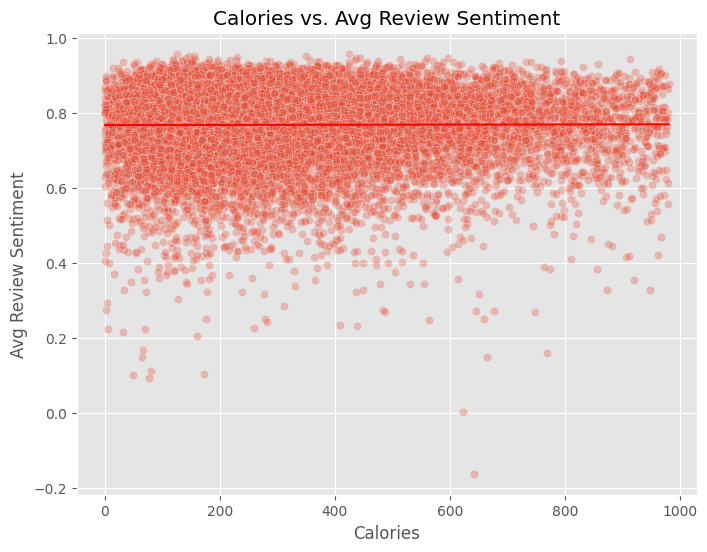

In [102]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=recipes_with_sentiment['calories'], y=recipes_with_sentiment['avg_review_sentiment'], alpha=0.3)
sns.lineplot(x=recipes_with_sentiment['calories'], y=predictions, color='red')
plt.title('Calories vs. Avg Review Sentiment')
plt.xlabel('Calories')
plt.ylabel('Avg Review Sentiment')
plt.grid(True)
plt.show()


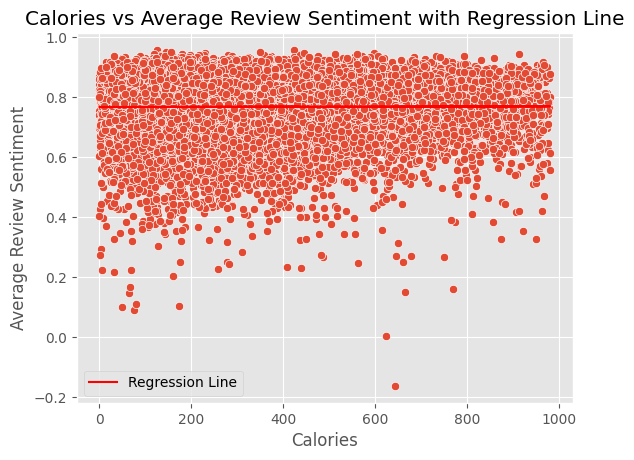

In [103]:
sns.scatterplot(data=recipes_with_sentiment, x='calories', y='avg_review_sentiment')
plt.plot(recipes_with_sentiment['calories'], predictions, color='red', label='Regression Line')
plt.title('Calories vs Average Review Sentiment with Regression Line')
plt.xlabel('Calories')
plt.ylabel('Average Review Sentiment')
plt.legend()
plt.show()

# 3. Do minutes and steps in recipes correlate?

- YES

In [104]:
recipes_df['minutes'] = pd.to_numeric(recipes_df['minutes'], errors='coerce')
recipes_df['n_steps'] = pd.to_numeric(recipes_df['n_steps'], errors='coerce')

recipes_df = recipes_df.dropna(subset=['minutes', 'n_steps'])

X = recipes_df[['minutes']]
y = recipes_df['n_steps']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                n_steps   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1561.
Date:                Fri, 17 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:48:35   Log-Likelihood:                -56839.
No. Observations:               18443   AIC:                         1.137e+05
Df Residuals:                   18441   BIC:                         1.137e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6564      0.057    135.311      0.0

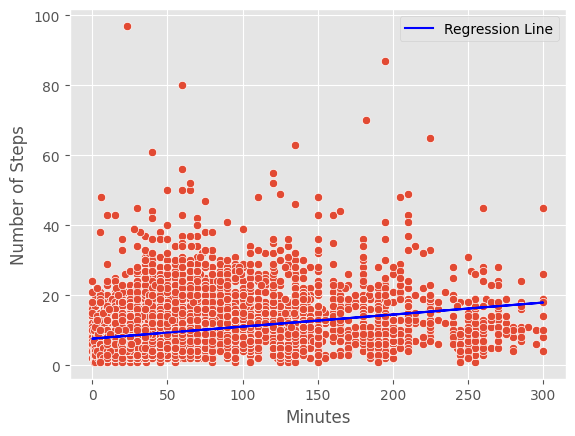

In [105]:
sns.scatterplot(data=recipes_df, x='minutes', y='n_steps')
plt.plot(recipes_df['minutes'], predictions, color='blue', label='Regression Line')
#plt.title('Minutes vs Number of Steps')
plt.xlabel('Minutes')
plt.ylabel('Number of Steps')
plt.legend()
plt.show()

# 4. Create a complexity feature from minutes and steps

In [106]:
recipes_df['complexity'] = recipes_df['minutes'] * recipes_df['n_steps']

print(recipes_df[['recipe_id', 'complexity']].head())

    recipe_id  complexity
16      43026         405
17      23933          60
33      54100         338
34      67664          30
36      25775         250


In [107]:
recipes_df[recipes_df.recipe_id == 155959]

name  recipe_id  minutes  contributor_id  \
147  ant  kelly s london broil marinade     155959      200           59476   

      submitted                                               tags  n_steps  \
147  2006-02-13  ['time-to-make', 'main-ingredient', 'preparati...       13   

                                                 steps  \
147  ['mix all marinade ingredients together', 'lig...   

                                           description  \
147  my niece shwana loves this!  she always writes...   

                                           ingredients  ...  calories   fat  \
147  [balsamic vinegar, soy sauce, worcestershire s...  ...     673.5  61.0   

     sugar  sodium  protein  saturated_fat  carb  recipe_VADER_compound  \
147   18.0     2.0    133.0           57.0   2.0                 0.6879   

     recipe_VADER_class complexity  
147            Positive       2600  

[1 rows x 21 columns]

# 5. Do less complex recipes have more reviews?

- NO, more complex have more reviews

In [108]:
recipes_with_complexity = pd.merge(recipes_with_reviews, recipes_df[['recipe_id', 'complexity']], on='recipe_id')

In [109]:
recipes_with_complexity['complexity'] = pd.to_numeric(recipes_with_complexity['complexity'], errors='coerce')
recipes_with_complexity['review_count'] = pd.to_numeric(recipes_with_complexity['review_count'], errors='coerce')

recipes_with_complexity = recipes_with_complexity.dropna(subset=['complexity', 'review_count'])

X = recipes_with_complexity[['complexity']]
y = recipes_with_complexity['review_count']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     21.59
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           3.40e-06
Time:                        20:54:46   Log-Likelihood:                -98863.
No. Observations:               18443   AIC:                         1.977e+05
Df Residuals:                   18441   BIC:                         1.977e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.9090      0.463     58.154      0.0

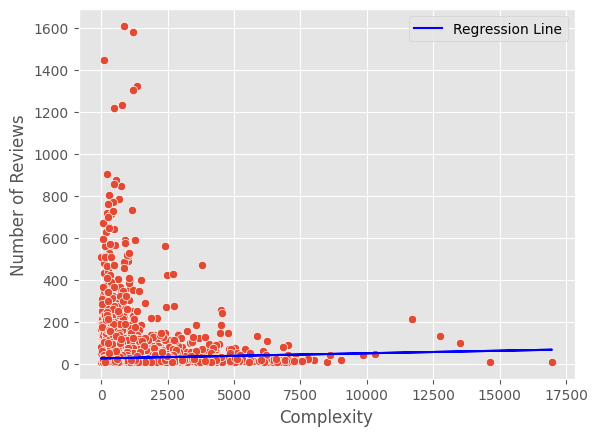

In [110]:
sns.scatterplot(data=recipes_with_complexity, x='complexity', y='review_count')
plt.plot(recipes_with_complexity['complexity'], predictions, color='blue', label='Regression Line')
#plt.title('Complexity vs Number of Reviews')
plt.xlabel('Complexity')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

# 6. Do less complex recipes have reviews with more positive sentiment?

- NO

In [111]:
recipes_with_complexity_sentiment = pd.merge(recipes_with_sentiment, recipes_df[['recipe_id', 'complexity']], on='recipe_id')

In [ ]:
recipes_with_complexity_sentiment['complexity'] = pd.to_numeric(recipes_with_complexity_sentiment['complexity'], errors='coerce')
recipes_with_complexity_sentiment['avg_review_sentiment'] = pd.to_numeric(recipes_with_complexity_sentiment['avg_review_sentiment'], errors='coerce')

recipes_with_complexity_sentiment = recipes_with_complexity_sentiment.dropna(subset=['complexity', 'avg_review_sentiment'])

X = recipes_with_complexity_sentiment[['complexity']]
y = recipes_with_complexity_sentiment['avg_review_sentiment']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_review_sentiment   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     1.745
Date:                  Fri, 17 Jan 2025   Prob (F-statistic):              0.186
Time:                          20:55:23   Log-Likelihood:                 17494.
No. Observations:                 18443   AIC:                        -3.498e+04
Df Residuals:                     18441   BIC:                        -3.497e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7692      0.001

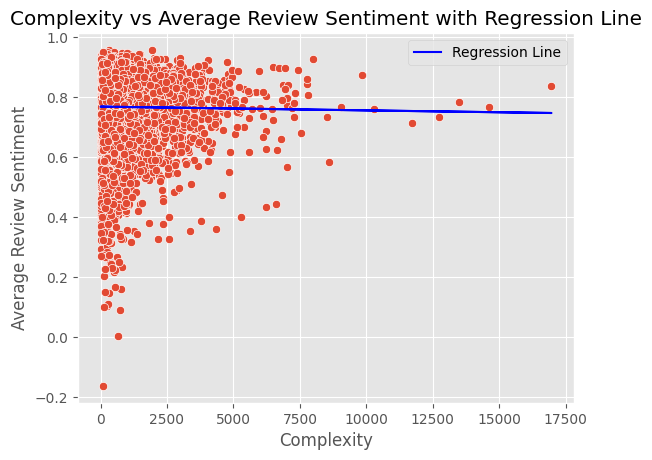

In [113]:
sns.scatterplot(data=recipes_with_complexity_sentiment, x='complexity', y='avg_review_sentiment')
plt.plot(recipes_with_complexity_sentiment['complexity'], predictions, color='blue', label='Regression Line')
plt.title('Complexity vs Average Review Sentiment with Regression Line')
plt.xlabel('Complexity')
plt.ylabel('Average Review Sentiment')
plt.legend()
plt.show()

# 7. Does recipe sentiment correlate with the sentiment of its reviews?

- YES

In [114]:
recipes_with_sentiment['recipe_VADER_compound'] = pd.to_numeric(recipes_with_sentiment['recipe_VADER_compound'], errors='coerce')
recipes_with_sentiment['avg_review_sentiment'] = pd.to_numeric(recipes_with_sentiment['avg_review_sentiment'], errors='coerce')

recipes_with_sentiment = recipes_with_sentiment.dropna(subset=['recipe_VADER_compound', 'avg_review_sentiment'])

X = recipes_with_sentiment[['recipe_VADER_compound']]
y = recipes_with_sentiment['avg_review_sentiment']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_review_sentiment   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     25.90
Date:                  Fri, 17 Jan 2025   Prob (F-statistic):           3.62e-07
Time:                          20:55:25   Log-Likelihood:                 17506.
No. Observations:                 18443   AIC:                        -3.501e+04
Df Residuals:                     18441   BIC:                        -3.499e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

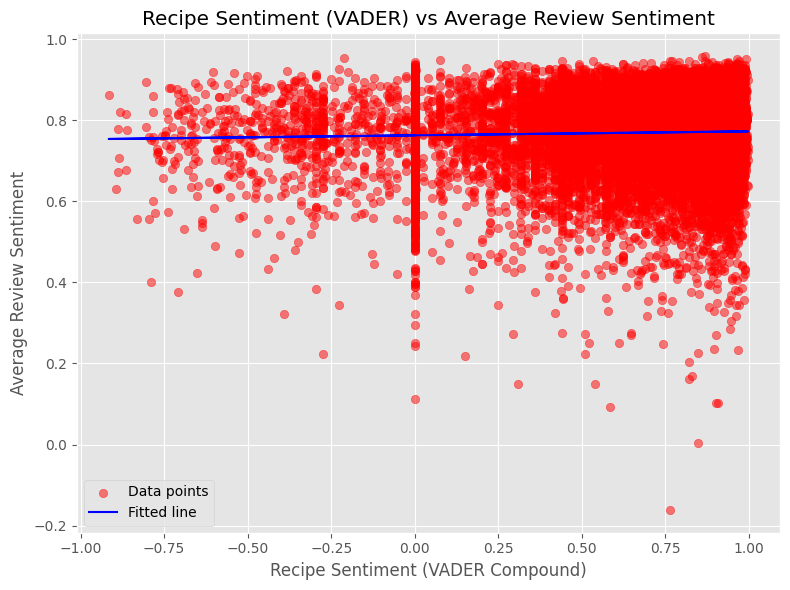

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(recipes_with_sentiment['recipe_VADER_compound'], recipes_with_sentiment['avg_review_sentiment'], alpha=0.5, color='red', label='Data points')
plt.plot(recipes_with_sentiment['recipe_VADER_compound'], model.predict(sm.add_constant(recipes_with_sentiment[['recipe_VADER_compound']])), color='b', label='Fitted line')
plt.title('Recipe Sentiment (VADER) vs Average Review Sentiment')
plt.xlabel('Recipe Sentiment (VADER Compound)')
plt.ylabel('Average Review Sentiment')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

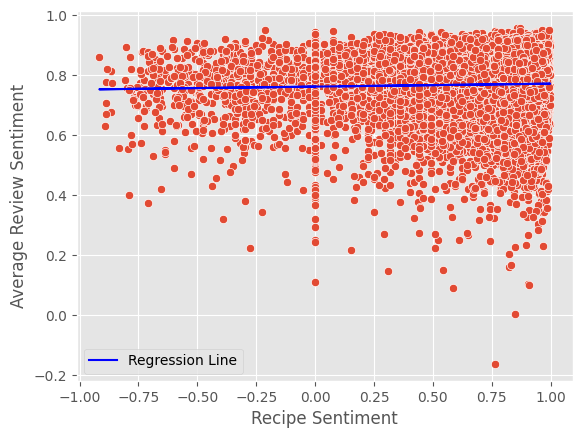

In [117]:
sns.scatterplot(data=recipes_with_sentiment, x='recipe_VADER_compound', y='avg_review_sentiment')
plt.plot(recipes_with_sentiment['recipe_VADER_compound'], predictions, color='blue', label='Regression Line')
#plt.title('Recipe Sentiment vs Average Reviews Sentiment')
plt.xlabel('Recipe Sentiment')
plt.ylabel('Average Review Sentiment')
plt.legend()
plt.show()

# 8. Wordcloud of most common ingredients in the recipes

In [118]:
all_ingredients = ' '.join(recipes_df['ingredients'].sum())
all_ingredients


'egg roll wrap whole green chilies cheese cornstarch oil butterscotch chips chinese noodles salted peanuts ground venison egg substitute non-fat powdered milk water fresh breadcrumb onion salt black pepper dry mustard worcestershire sauce milk frozen juice concentrate plain yogurt frozen chopped spinach egg salt black pepper onion sharp cheddar cheese condensed cream of mushroom soup crouton angel hair pasta toasted sesame oil soy sauce honey garlic green onions toasted sesame seeds stir fry vegetables ground beef sugar prepared yellow mustard beer cayenne garlic salt & pepper american cheese rolls brown sugar instant vanilla pudding cinnamon raisins butter whipping cream vanilla instant pudding mix powdered sugar vanilla extract carrots butter onion sliced mushrooms zucchini celery green pepper cloves tomatoes chili powder ground cumin oregano cayenne pepper flour water monterey jack cheese salt all-purpose flour baking powder vegetable shortening soy sauce egg sweet corn sweet butter

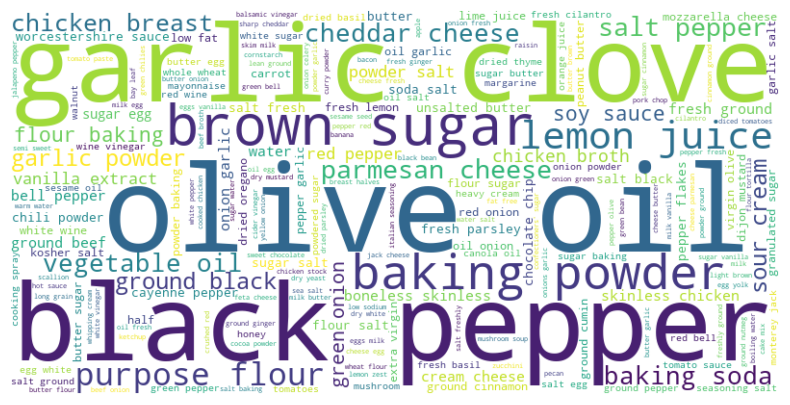

In [119]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 9. Do recipes with more sugar or sodium get more reviews and have higher review sentiment?

- It doesn't matter

In [120]:
recipes_with_sentiment_and_reviews = pd.merge(recipes_with_sentiment, recipes_with_reviews[['recipe_id', 'review_count']], on='recipe_id', how='left')

print(recipes_with_sentiment_and_reviews[['recipe_id', 'review_count', 'avg_review_sentiment']].head())


   recipe_id  review_count  avg_review_sentiment
0      43026            22              0.801659
1      23933            12              0.711925
2      54100            14              0.820786
3      67664            12              0.839067
4      25775           113              0.688558


In [121]:
X_reviews = recipes_with_sentiment_and_reviews[['sugar', 'sodium']]
y_reviews = recipes_with_sentiment_and_reviews['review_count']
X_reviews = sm.add_constant(X_reviews) 

model_reviews = sm.OLS(y_reviews, X_reviews).fit()

print(model_reviews.summary())

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.057
Date:                Fri, 17 Jan 2025   Prob (F-statistic):              0.128
Time:                        20:56:16   Log-Likelihood:                -98872.
No. Observations:               18443   AIC:                         1.977e+05
Df Residuals:                   18440   BIC:                         1.978e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3043      0.561     48.678      0.0

In [122]:
X_sentiment = recipes_with_sentiment_and_reviews[['sugar', 'sodium']]
y_sentiment = recipes_with_sentiment_and_reviews['avg_review_sentiment']
X_sentiment = sm.add_constant(X_sentiment) 

model_sentiment = sm.OLS(y_sentiment, X_sentiment).fit()

print(model_sentiment.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_review_sentiment   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.000
Method:                   Least Squares   F-statistic:                   0.06528
Date:                  Fri, 17 Jan 2025   Prob (F-statistic):              0.937
Time:                          20:56:16   Log-Likelihood:                 17494.
No. Observations:                 18443   AIC:                        -3.498e+04
Df Residuals:                     18440   BIC:                        -3.496e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7688      0.001

In [123]:
print(recipes_with_sentiment_and_reviews[['sugar', 'sodium', 'review_count']].corr())

print(recipes_with_sentiment_and_reviews[['sugar', 'sodium', 'avg_review_sentiment']].corr())


                 sugar    sodium  review_count
sugar         1.000000  0.691000      0.007604
sodium        0.691000  1.000000      0.014547
review_count  0.007604  0.014547      1.000000
                         sugar    sodium  avg_review_sentiment
sugar                 1.000000  0.691000             -0.001949
sodium                0.691000  1.000000             -0.002656
avg_review_sentiment -0.001949 -0.002656              1.000000


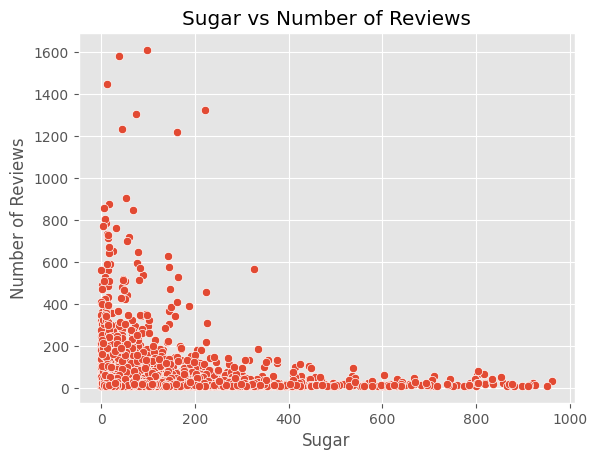

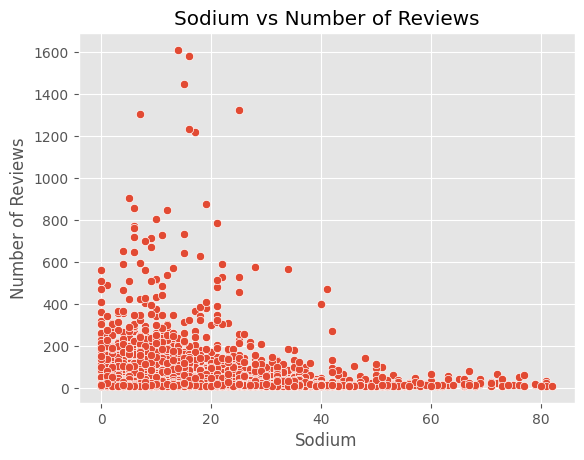

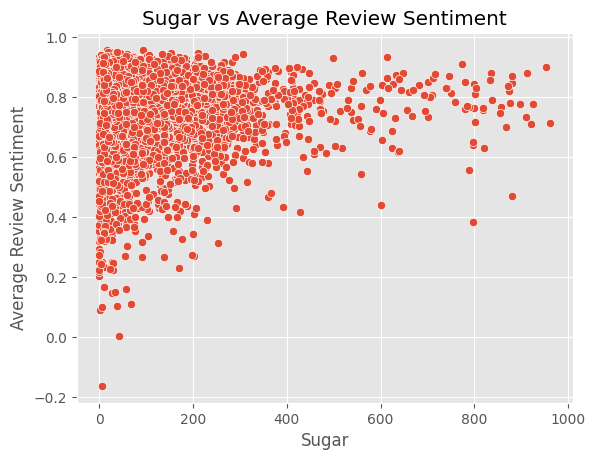

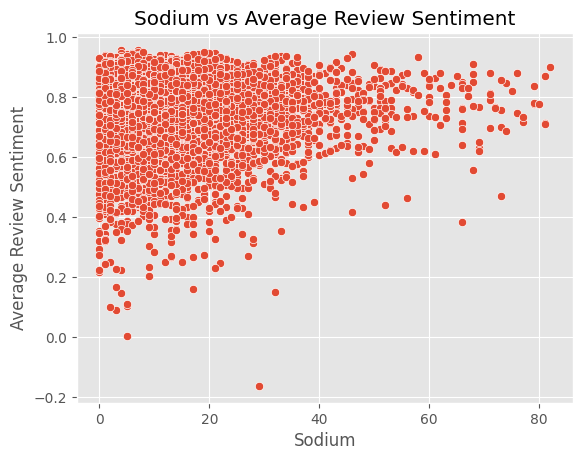

In [124]:
sns.scatterplot(data=recipes_with_sentiment_and_reviews, x='sugar', y='review_count')
plt.title('Sugar vs Number of Reviews')
plt.xlabel('Sugar')
plt.ylabel('Number of Reviews')
plt.show()

sns.scatterplot(data=recipes_with_sentiment_and_reviews, x='sodium', y='review_count')
plt.title('Sodium vs Number of Reviews')
plt.xlabel('Sodium')
plt.ylabel('Number of Reviews')
plt.show()

sns.scatterplot(data=recipes_with_sentiment_and_reviews, x='sugar', y='avg_review_sentiment')
plt.title('Sugar vs Average Review Sentiment')
plt.xlabel('Sugar')
plt.ylabel('Average Review Sentiment')
plt.show()

sns.scatterplot(data=recipes_with_sentiment_and_reviews, x='sodium', y='avg_review_sentiment')
plt.title('Sodium vs Average Review Sentiment')
plt.xlabel('Sodium')
plt.ylabel('Average Review Sentiment')
plt.show()

# Best of

In [125]:
best_of = recipes_with_sentiment_and_reviews.copy()

In [126]:
best_of['weighted_sentiment'] = best_of['avg_review_sentiment'] * best_of['review_count']

In [127]:
max_reviews = best_of['review_count'].max()
best_of['normalized_weighted_sentiment'] = best_of['weighted_sentiment'] / max_reviews

In [128]:
filtered_recipes = best_of[best_of['minutes'] <= 30]

sorted_recipes = filtered_recipes.sort_values(by=['normalized_weighted_sentiment'], ascending=False)

In [129]:
sorted_recipes.head()

name  recipe_id  minutes  \
5029                          creamy cajun chicken pasta      39087       25   
16765           the best easy beef and broccoli stir fry      99476       25   
15427                       southern buttermilk biscuits      26110       22   
15323                         soft snickerdoodle cookies      97496       25   
7150   fudge crinkles  a great 4 ingredient cake mix ...      32614       15   

       contributor_id   submitted  \
5029            30534  2002-09-02   
16765          103876  2004-09-09   
15427           38532  2002-04-22   
15323          156653  2004-08-10   
7150            37305  2002-06-30   

                                                    tags  n_steps  \
5029   ['30-minutes-or-less', 'time-to-make', 'course...        4   
16765  ['lactose', '30-minutes-or-less', 'time-to-mak...       11   
15427  ['30-minutes-or-less', 'time-to-make', 'course...       21   
15323  ['30-minutes-or-less', 'time-to-make', 'course...       10   
7150   ['15-minutes-or-less', 'time-to-make', 'course...       20   

                                                   steps  \
5029   ['place chicken and cajun seasoning in a bowl ...   
16765  ['in a bowl , combine 2 tablespoons cornstarch...   
15427  ['preheat your oven to 450f', 'combine the dry...   
15323  ['preheat oven to 350f', 'mix softened butter ...   
7150   ['preheat oven to 350', 'stir dry cake mix , o...   

                                             description  \
5029   n'awlin's style of chicken with an updated alf...   
16765  i clipped this recipe from taste of home magaz...   
15427  these buttermilk biscuits are authentic. this ...   
15323  these snickerdoodle cookies are so delicious, ...   
7150   these are chewy, fudgy, super easy cookies tha...   

                                             ingredients  ...  sodium  \
5029   [boneless skinless chicken breast halves, ling...  ...    15.0   
16765  [cornstarch, water, garlic powder, boneless ro...  ...     6.0   
15427  [unbleached all-purpose flour, baking soda, ba...  ...     6.0   
15323  [butter, sugar, eggs, flour, cream of tartar, ...  ...     8.0   
7150   [devil's food cake mix, vegetable oil, eggs, c...  ...     4.0   

       protein  saturated_fat  carb  recipe_VADER_compound  \
5029      78.0          120.0  15.0                 0.0000   
16765      7.0            4.0   6.0                 0.7845   
15427      6.0           22.0   6.0                 0.9484   
15323      4.0           25.0   8.0                 0.9629   
7150       2.0            5.0   4.0                 0.9522   

       recipe_VADER_class  avg_review_sentiment  review_count  \
5029              Neutral              0.788738          1448   
16765            Positive              0.762703           760   
15427            Positive              0.727825           769   
15323            Positive              0.740128           701   
7150             Positive              0.779732           652   

       weighted_sentiment normalized_weighted_sentiment  
5029            1142.0933                      0.709816  
16765            579.6543                      0.360257  
15427            559.6972                      0.347854  
15323            518.8295                      0.322455  
7150             508.3852                      0.315963  

[5 rows x 24 columns]

In [130]:
sorted_recipes.description.values

array(["n'awlin's style of chicken with an updated alfredo sauce.",
       "i clipped this recipe from taste of home magazine several years ago and have found it to be the best-tasting easy beef and broccoli stir-fry. it is credited to ruth stahl. i often use charcoal chuck steak, which is very tender and lean. i also like that it doesn't call for any unusual ingredients.",
       "these buttermilk biscuits are authentic. this recipe came from my great-great-grandmother, and was handed down to all the women in my family, and we are all southern. i am the first one to commit the sin of using a food processor (lol) but i find it works very well. i would put these biscuits up against anyone's - they are perfect in every single way. i hope you all enjoy them.",
       ...,
       'these pancakes freeze very well!  make them small for toddlers to hold or larger for the rest of the family.  i like to use flavored (blueberry, strawberry, etc) applesauce without any added sugar.  if you use a 

# Best / Worst reviews

In [131]:
interactions_df.shape

(557943, 7)

In [132]:
merged_df.shape

(519002, 26)

In [133]:
merged_df.head()

name  recipe_id  minutes  contributor_id   submitted  \
0  chile rellenos      43026       45           52268  2002-10-14   
1  chile rellenos      43026       45           52268  2002-10-14   
2  chile rellenos      43026       45           52268  2002-10-14   
3  chile rellenos      43026       45           52268  2002-10-14   
4  chile rellenos      43026       45           52268  2002-10-14   

                                                tags  n_steps  \
0  ['60-minutes-or-less', 'time-to-make', 'course...        9   
1  ['60-minutes-or-less', 'time-to-make', 'course...        9   
2  ['60-minutes-or-less', 'time-to-make', 'course...        9   
3  ['60-minutes-or-less', 'time-to-make', 'course...        9   
4  ['60-minutes-or-less', 'time-to-make', 'course...        9   

                                               steps  \
0  ['drain green chiles', 'sprinkle cornstarch on...   
1  ['drain green chiles', 'sprinkle cornstarch on...   
2  ['drain green chiles', 'sprinkle cornstarch on...   
3  ['drain green chiles', 'sprinkle cornstarch on...   
4  ['drain green chiles', 'sprinkle cornstarch on...   

                                         description  \
0  a favorite from a local restaurant no longer i...   
1  a favorite from a local restaurant no longer i...   
2  a favorite from a local restaurant no longer i...   
3  a favorite from a local restaurant no longer i...   
4  a favorite from a local restaurant no longer i...   

                                         ingredients  ...  saturated_fat  \
0  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
1  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
2  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
3  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
4  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   

   carb  recipe_VADER_compound  recipe_VADER_class  user_id        date  \
0   0.0                 0.1027             Neutral    22973  2003-05-22   
1   0.0                 0.1027             Neutral    41578  2003-06-12   
2   0.0                 0.1027             Neutral    44372  2004-02-18   
3   0.0                 0.1027             Neutral   142658  2004-06-04   
4   0.0                 0.1027             Neutral   133625  2004-07-03   

   rating                                             review  \
0       5  Grandma Pam,\r\n  Oh my goodness,these were so...   
1       5  WOW!  When you need a Mexican fix, this is the...   
2       5  OMG!  If I could give this recipe more than 5 ...   
3       5  I have been searching for this recipe.  My hus...   
4       5  How easy and yummy!  I am always looking for a...   

   review_VADER_compound review_VADER_class  
0                 0.8907           Positive  
1                 0.9682           Positive  
2                 0.9391           Positive  
3                 0.9541           Positive  
4                 0.9431           Positive  

[5 rows x 26 columns]

In [134]:
best_5_reviews = merged_df.nlargest(5, "review_VADER_compound")

In [135]:
best_5_reviews[["review", "review_VADER_compound", "name"]]

review  \
490278  Deeelicious! I love fried potatoes and I haven...   
460946  Spectacularly delicious! Thank you so much for...   
489334  I make pizza often. From finding the best doug...   
54543   I have made these about 6 or 7 times now, and ...   
188628  This is really the only recipe you need for ma...   

        review_VADER_compound                                             name  
490278                 0.9994           uncle bill s fried potatoes and onions  
460946                 0.9991                                thai tom kha soup  
489334                 0.9990                             ultimate pizza sauce  
54543                  0.9989                                best banana bread  
188628                 0.9989  fannie farmer s classic baked macaroni   cheese

In [136]:
with pd.option_context('display.max_colwidth', None):
    display(best_5_reviews[["review", "review_VADER_compound", "name"]])

review  \
490278                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Deeelicious! I love fried potatoes and I haven't had them in ages. I am so glad you posted this Uncle Bill! I had to sub a baking potato for the russet or yukon, margarine for the butter, and frozen chopped onion instead of sliced. The onions carmelized beautifully, the garlic powder, salt, and pepper are the perfect combo. I actually didn't measure the spices :) but that didn't cause a problem at all. I only used 1 medium-large size potato since I was the only one eating this. The only reason why this isn't getting 5 stars is that my potatoes didn't brown up at all. I even added an extra 5 ins at the end, and for some reason, they just wouldn't brown. They cooked through well though, and the onions even got browned and crispy (YUM!) I posted in the Cooking Q&A Forum as to why my potatoes might not have browned. This was still amazing though, still had the fried flavor. This is still a keeper for me. I made this for my lunch today. Here's an update; I'm upping my stars from 4-5 b/c after confirming my thoughts on my why my potatoes didn't brown, I really do believe that there is nothing wrong w/this recipe. :) Even if my technique or subs cause these potatoes never to brown for me, I will make this often. I am so pleased by the flavor and simplicity of this recipe, and the way the onions cooked up, that this will remain a staple for me. Thanks again Uncle Bill, my tummy loves you for this, a treat and a comfort food to me. :) I am back to add to my review! I give this 10 stars, especially b/c Uncle Bill offered a great suggestion which I used this time around to brown the potatoes: I started onions first until they were just starting to carmelize, then added in potato slices to brown (and they browned alright! lol) and then added onions back in to finish. I'm kind of miffed w/myself, as I got so excited that my potatoes browned using Uncle Bill's suggestion that I totally forgot to add in the sal, pepper, and garlic powder, and I already had them out of the pan. These taste better if you season them while they are still cooking, oh well. :) It also prob helped that I splurged and used real butter instead of margarine this time, too. Thanks again! :) An UPDATE to my previous ramblings, I mean reviews lol! This time used a russet, & bf bought the wrong onions (yellow instead of white, no biggie); & again I used margarine (gasp!) b/c I honestly don't mind the taste of it & it's easier on my tummy. With the fresh (not frozen) onion slices, even the marg didn't prevent this dish from browning. I went back to the original recipe instructions b/c I wanted to see if I could get the potatoes to brown by not using frozen onions. That's all it tok, really! I hope my experiences w/this recipe help others who are novice cooks like me; do I get a reward for longest review ever? Lol.  As promised, I came back (again) to say I tried a Vidalia sweet onion in this.  If you like a milder onion taste, a sweet onion is great. :)   
460946  Spectacularly delicious! Thank you so much for this inspiring recipe. This is one of my all-time favorite foods and this recipe is a very good one that is simple to make, and a great 

In [137]:
worst_5_reviews = merged_df.nsmallest(5, "review_VADER_compound")

In [138]:
worst_5_reviews[["review", "review_VADER_compound", "name"]]

review  \
341911  I HATE to do this but feel I need to as a poss...   
319286  I hate to sound rude but this is the absolute ...   
508311  After looking at all the reviews, I tried this...   
382681  This recipe is BAD BAD BAD...it may not be rec...   
406405  I can't give stars right now. I had high hopes...   

        review_VADER_compound                                          name  
341911                -0.9844  outback steakhouse gold coast coconut shrimp  
319286                -0.9831             most incredible no fail pie crust  
508311                -0.9814                   wonderful roasted prime rib  
382681                -0.9809     quick and easy cinnamon rolls  yeast free  
406405                -0.9808                          saucy bacon roll ups

In [139]:
with pd.option_context('display.max_colwidth', None):
    display(worst_5_reviews[["review", "review_VADER_compound", "name"]])

review  \
341911                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            I HATE to do this but feel I need to as a possible warning to others.  I printed and made this recipe (Shrimp only - not the dipping sauce) just a couple of days after the transition between Recipezaar and Food.com.  There are many, many complaints of ingredients in recipes not being accurate since the change.  I'm not sure if that's the case with this recipe or not but this recipe was a DISASTER for me and I followed it EXACTLY.  There was SO much batter it was an absolute waste.  Even though the shrimp were very dry the batter still wouldn't stick and I was left with nothing but a big globby mess especially after dipping in the dry coconut.  The batter wouldn't even stick long enough to get the shrimp from the platter in to the fryer and just slid right off in to the hot oil.  Very disappointing dinner and a waste of some really good ingredients.   
319286                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       I hate to sound rude but this is the absolute worst recipe I ever used.  There is no way that all these good reviews came from this recipe..I have been baking for a long time and I never had a crust taste as bad and fall apart  before getting it to the pan like t

# WordCloud

In [142]:
df = merged_df.copy()

In [143]:
df.head()

name  recipe_id  minutes  contributor_id   submitted  \
0  chile rellenos      43026       45           52268  2002-10-14   
1  chile rellenos      43026       45           52268  2002-10-14   
2  chile rellenos      43026       45           52268  2002-10-14   
3  chile rellenos      43026       45           52268  2002-10-14   
4  chile rellenos      43026       45           52268  2002-10-14   

                                                tags  n_steps  \
0  ['60-minutes-or-less', 'time-to-make', 'course...        9   
1  ['60-minutes-or-less', 'time-to-make', 'course...        9   
2  ['60-minutes-or-less', 'time-to-make', 'course...        9   
3  ['60-minutes-or-less', 'time-to-make', 'course...        9   
4  ['60-minutes-or-less', 'time-to-make', 'course...        9   

                                               steps  \
0  ['drain green chiles', 'sprinkle cornstarch on...   
1  ['drain green chiles', 'sprinkle cornstarch on...   
2  ['drain green chiles', 'sprinkle cornstarch on...   
3  ['drain green chiles', 'sprinkle cornstarch on...   
4  ['drain green chiles', 'sprinkle cornstarch on...   

                                         description  \
0  a favorite from a local restaurant no longer i...   
1  a favorite from a local restaurant no longer i...   
2  a favorite from a local restaurant no longer i...   
3  a favorite from a local restaurant no longer i...   
4  a favorite from a local restaurant no longer i...   

                                         ingredients  ...  saturated_fat  \
0  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
1  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
2  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
3  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   
4  [egg roll wrap, whole green chilies, cheese, c...  ...           21.0   

   carb  recipe_VADER_compound  recipe_VADER_class  user_id        date  \
0   0.0                 0.1027             Neutral    22973  2003-05-22   
1   0.0                 0.1027             Neutral    41578  2003-06-12   
2   0.0                 0.1027             Neutral    44372  2004-02-18   
3   0.0                 0.1027             Neutral   142658  2004-06-04   
4   0.0                 0.1027             Neutral   133625  2004-07-03   

   rating                                             review  \
0       5  Grandma Pam,\r\n  Oh my goodness,these were so...   
1       5  WOW!  When you need a Mexican fix, this is the...   
2       5  OMG!  If I could give this recipe more than 5 ...   
3       5  I have been searching for this recipe.  My hus...   
4       5  How easy and yummy!  I am always looking for a...   

   review_VADER_compound review_VADER_class  
0                 0.8907           Positive  
1                 0.9682           Positive  
2                 0.9391           Positive  
3                 0.9541           Positive  
4                 0.9431           Positive  

[5 rows x 26 columns]

In [144]:
df.review_VADER_class.value_counts()

review_VADER_class
Positive    454426
Neutral      58026
Negative      6550
Name: count, dtype: int64

In [145]:
import spacy
 
nlp = spacy.load("en_core_web_sm")

In [146]:
stopwords = set(nlp.Defaults.stop_words)

stopwords_pattern = r'\b(' + r'|'.join(stopwords) + r')\b'

df['review_cleaned'] = df['review'].str.replace(stopwords_pattern, '', regex=True)

df['review_cleaned'] = df['review_cleaned'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()

In [149]:
df[["review", "review_cleaned"]]

review  \
0       Grandma Pam,\r\n  Oh my goodness,these were so...   
1       WOW!  When you need a Mexican fix, this is the...   
2       OMG!  If I could give this recipe more than 5 ...   
3       I have been searching for this recipe.  My hus...   
4       How easy and yummy!  I am always looking for a...   
...                                                   ...   
518997  I love this soup and this was no exception!  I...   
518998  This recipe is awesome! I go to Olive garden a...   
518999  Delicious!  I looked a lot of recipes over bef...   
519000  I have been using a different &quot;clone&quot...   
519001  I figured I&#039;d be kind &amp; give 2 stars ...   

                                           review_cleaned  
0       Grandma Pam Oh goodness easy good We dipped sa...  
1       WOW When need Mexican fix recipe try These eas...  
2       OMG If I recipe stars I I loved ease prep flav...  
3       I searching recipe My husbands aunt loved I lo...  
4       How easy yummy I looking ahead recipe My DH I ...  
...                                                   ...  
518997  I love soup exception I spicy turkey sausage c...  
518998  This recipe awesome I Olive garden buy unbaked...  
518999  Delicious I looked lot recipes settling Chef W...  
519000  I different quotclonequot lower fat amp calori...  
519001  I figured Id kind amp stars heart relying star...  

[519002 rows x 2 columns]

In [151]:
df_wc = df[["review_cleaned", "review_VADER_class", "review_VADER_compound"]].copy()
df_wc.review_VADER_class.value_counts()

review_VADER_class
Positive    454426
Neutral      58026
Negative      6550
Name: count, dtype: int64

In [152]:
df_wc.head()

review_cleaned review_VADER_class  \
0  Grandma Pam Oh goodness easy good We dipped sa...           Positive   
1  WOW When need Mexican fix recipe try These eas...           Positive   
2  OMG If I recipe stars I I loved ease prep flav...           Positive   
3  I searching recipe My husbands aunt loved I lo...           Positive   
4  How easy yummy I looking ahead recipe My DH I ...           Positive   

   review_VADER_compound  
0                 0.8907  
1                 0.9682  
2                 0.9391  
3                 0.9541  
4                 0.9431

C:\Users\Gabriela\AppData\Local\Temp\ipykernel_36780\301983651.py:10: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  positive_word_freq = pd.value_counts(positive_text.split())
C:\Users\Gabriela\AppData\Local\Temp\ipykernel_36780\301983651.py:10: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  positive_word_freq = pd.value_counts(positive_text.split())
C:\Users\Gabriela\AppData\Local\Temp\ipykernel_36780\301983651.py:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  negative_word_freq = pd.value_counts(negative_text.split())
C:\Users\Gabriela\AppData\Local\Temp\ipykernel_36780\301983651.py:11: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is depre

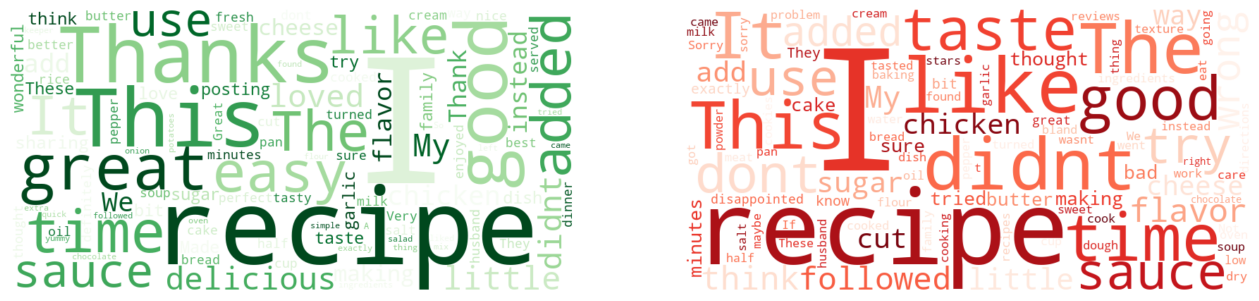

In [153]:

positive_reviews = df_wc[df_wc['review_VADER_class'] == 'Positive']['review_cleaned']
negative_reviews = df_wc[df_wc['review_VADER_class'] == 'Negative']['review_cleaned']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

positive_word_freq = pd.value_counts(positive_text.split())
negative_word_freq = pd.value_counts(negative_text.split())

positive_word_freq_normalized = positive_word_freq / positive_word_freq.sum()
negative_word_freq_normalized = negative_word_freq / negative_word_freq.sum()

N = 100
positive_top_words = positive_word_freq_normalized.head(N)
negative_top_words = negative_word_freq_normalized.head(N)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(positive_top_words)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(negative_top_words)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
#lt.title('Positive Reviews')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
#plt.title('Negative Reviews')
plt.axis('off')

plt.show()

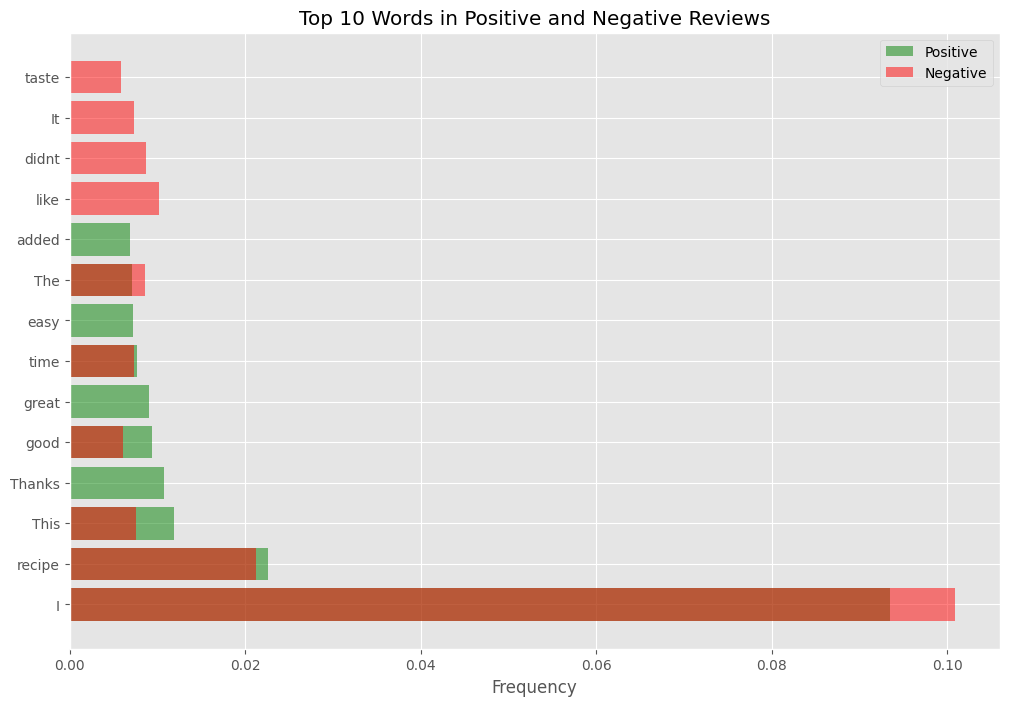

In [294]:
positive_top_words = positive_word_freq_normalized.head(10)
negative_top_words = negative_word_freq_normalized.head(10)

positive_df = positive_top_words.reset_index(name='frequency')
positive_df['sentiment'] = 'Positive'
negative_df = negative_top_words.reset_index(name='frequency')
negative_df['sentiment'] = 'Negative'

combined_df = pd.concat([positive_df, negative_df])

plt.figure(figsize=(12, 8))

plt.barh(combined_df[combined_df['sentiment'] == 'Positive']['index'],
         combined_df[combined_df['sentiment'] == 'Positive']['frequency'], 
         color='green', label='Positive', alpha=0.5)
plt.barh(combined_df[combined_df['sentiment'] == 'Negative']['index'],
         combined_df[combined_df['sentiment'] == 'Negative']['frequency'], 
         color='red', label='Negative', alpha=0.5)

plt.xlabel('Frequency')
plt.title('Top 10 Words in Positive and Negative Reviews')
plt.legend()
plt.show()

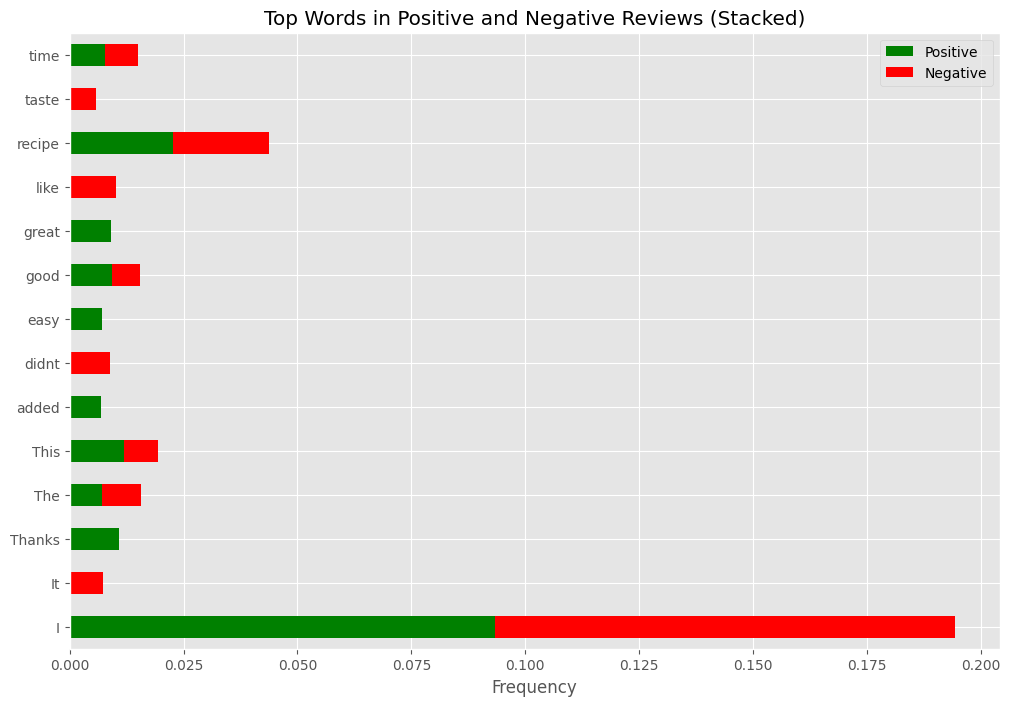

In [295]:
common_words = pd.merge(positive_top_words.head(N), negative_top_words.head(N), left_index=True, right_index=True, how='outer')
common_words.columns = ['Positive', 'Negative']

common_words.plot(kind='barh', stacked=True, color=['green', 'red'], figsize=(12, 8))

plt.xlabel('Frequency')
plt.title('Top Words in Positive and Negative Reviews (Stacked)')
plt.show()

C:\Users\Gabriela\AppData\Local\Temp\ipykernel_7580\1957803055.py:13: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sns.countplot(y='word', hue='sentiment', data=words_df, order=pd.value_counts(words_df['word']).index[:20], palette=['green', 'red'])


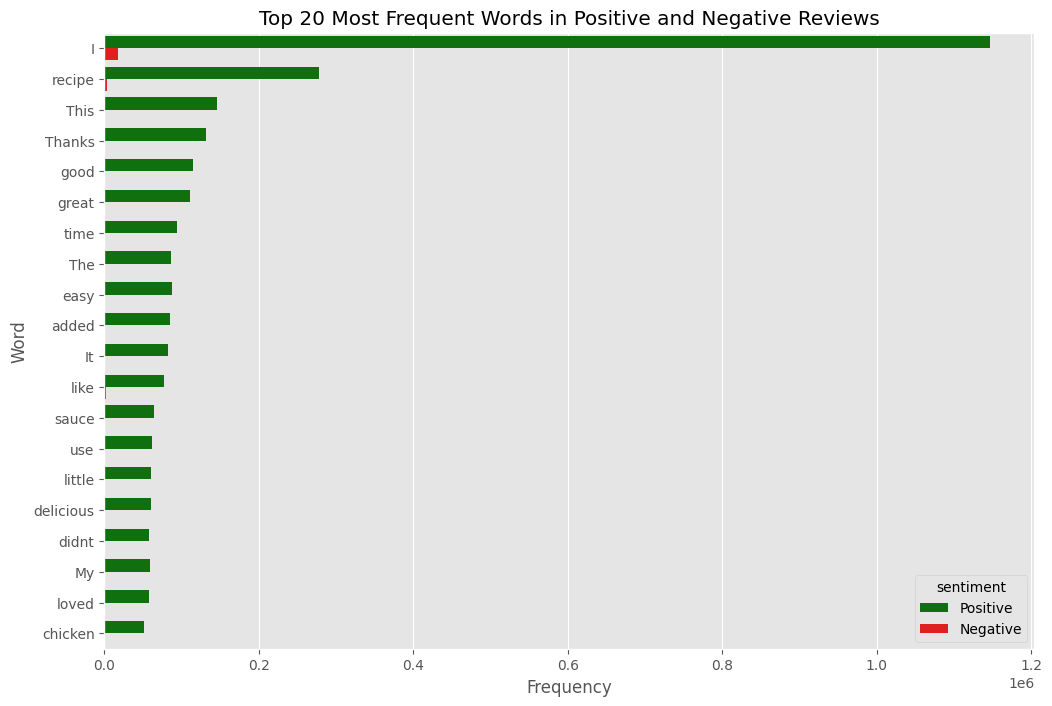

In [296]:
positive_words = positive_text.split()
negative_words = negative_text.split()

words_df = pd.DataFrame({
    'word': positive_words + negative_words,
    'sentiment': ['Positive'] * len(positive_words) + ['Negative'] * len(negative_words)
})

plt.figure(figsize=(12, 8))
sns.countplot(y='word', hue='sentiment', data=words_df, order=pd.value_counts(words_df['word']).index[:20], palette=['green', 'red'])
plt.title('Top 20 Most Frequent Words in Positive and Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

Color indicates relative frequency (darker shades = more frequent).
Size indicates absolute frequency (larger = more frequent).

This will create two word clouds: one for positive reviews and one for negative reviews, with the words' size representing their relative frequency and their color indicating the review sentiment (darker shades for higher positive sentiment).